### Imports & Utilities


In [1]:
import math, torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# --- plotting helpers
def _minmax(img):
    """
    Simple min-max normalization per image/map to display meaningful contrast
    Otherwise many maps look almost black
    """
    img = img.astype(np.float32)
    img -= img.min()
    img /= (img.max() + 1e-6)
    return img

def show_feature_maps(feat, title, per_row=8, limit=None):
    """
    feat: tensor [B, C, H, W] (we take B=1)
    Visualize up to 'limit' channels as grayscale tiles.
    """
    fm = feat[0]                          # take the first image
    fm = fm.detach().cpu().numpy()        # -> [C,H,W]
    C, H, W = fm.shape
    print(f'Number of Channels in Feature Map: {C}')
    print(f'Feature Map Dimension (H x W): {H} x {W}')
    if limit is not None:
        C = min(C, limit)
        fm = fm[:C]
    cols = per_row
    rows = int(np.ceil(C / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    axes = np.array(axes).reshape(rows, cols)
    for i in range(rows*cols):
        ax = axes[i//cols, i%cols]
        ax.axis("off")
        if i < C:
            ax.imshow(_minmax(fm[i]), cmap="gray")
            ax.set_title(f"fm {i}", fontsize=8)
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

def show_conv_kernels(conv_weight, title, per_row=8, show_channel_slices=True, limit=None):
    """
    conv_weight: tensor [out_c, in_c, kH, kW]
    - If show_channel_slices: tile each kernel's input-channel slices side-by-side (shows kernel depth)
    - Else: show an averaged slice per kernel (quick look)
    """
    W = conv_weight.detach().cpu().numpy()
    out_c, in_c, kH, kW = W.shape
    print(f'Number of Kernels: {out_c}')
    print(f'Each Kernel has {in_c} Channels - coming from previous layer.')
    print(f'Kernel Dimension (kH x kW): {kH} x {kW}')
    if limit is not None:
        out_c = min(out_c, limit)
        W = W[:out_c]
    cols = per_row
    rows = int(math.ceil(out_c / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    axes = np.array(axes).reshape(rows, cols)
    for idx in range(rows*cols):
        ax = axes[idx//cols, idx%cols]
        ax.axis("off")
        if idx >= out_c:
            continue
        if show_channel_slices:
            strip = np.concatenate([_minmax(W[idx, c]) for c in range(in_c)], axis=1)  # [kH, in_c*kW]
            ax.imshow(strip, cmap="gray")
        else:
            ax.imshow(_minmax(W[idx].mean(0)), cmap="gray")
        ax.set_title(f"k{idx} (Cin={in_c})", fontsize=8)
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


`IMG_PATH` can be modified to fit your input image.

In [3]:
IMG_PATH = 'cat.png'               # Update to the path to your input image 
img = Image.open(IMG_PATH).convert("RGB")

In [4]:
class TinyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Conv1:
        '''
        in_channels = 3 because we are passing in RGB image (which has 3 channels) initially
        out_channels = 8 means we want 8 kernels in the 1st Convolutional Layer
        '''
        # Conv2:
        '''
        in_channels = 8 because from last layer we have 8 (channels) feature maps
        out_channels = 16 means we want 16 kernels in the 2nd Convolutional Layer
        '''
        # Can alter out_channels to increase/decrease the number of feature maps
        # Feel free to alter the kernel_size/stride to see its effect 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, stride=1, padding=2)   
        self.relu1 = nn.ReLU(inplace=False)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1)  # Update in_channels if you modified the out_channels in conv1
        self.relu2 = nn.ReLU(inplace=False)

    def forward(self, x):
        x = self.relu1(self.conv1(x))   # feature maps L1: shape [B, 8, H, W]
        x = self.relu2(self.conv2(x))   # feature maps L2: shape [B, 16, H/2, W/2] due to stride=2
        return x

model = TinyCNN().eval()

In [5]:
tiny_preproc = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),                    # from [0, 255] integer input to [0,1] float tensor, shape [3,H,W]
])

x = tiny_preproc(img).unsqueeze(0)            # -> [1,3,224,224] adds a batch dimension (B=1) so the shape fits [B, C, H, W] expected by Conv2d

In [6]:
# Hook the layers to capture feature maps
acts = {}
def save_acts(name):
    def hook(module, inp, out):
        acts[name] = out
    return hook

h1 = model.conv1.register_forward_hook(save_acts("conv1"))
h2 = model.conv2.register_forward_hook(save_acts("conv2"))

In [7]:
# Forward pass
with torch.no_grad():
    _ = model(x)

Number of Kernels: 8
Each Kernel has 3 Channels - coming from previous layer.
Kernel Dimension (kH x kW): 5 x 5


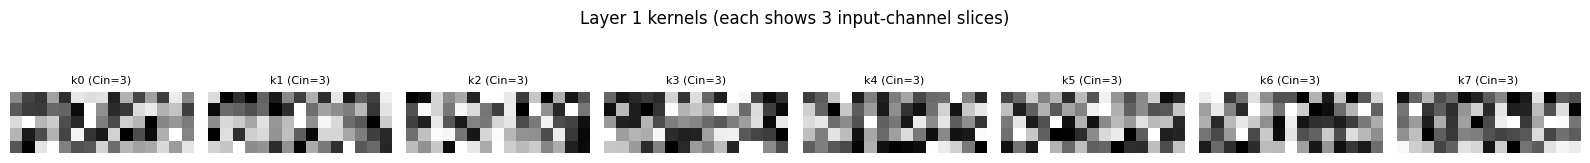

Number of Channels in Feature Map: 8
Feature Map Dimension (H x W): 224 x 224


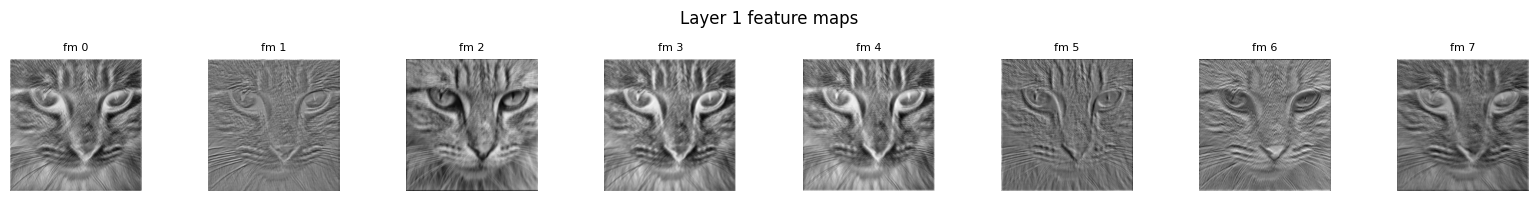

Number of Kernels: 16
Each Kernel has 8 Channels - coming from previous layer.
Kernel Dimension (kH x kW): 3 x 3


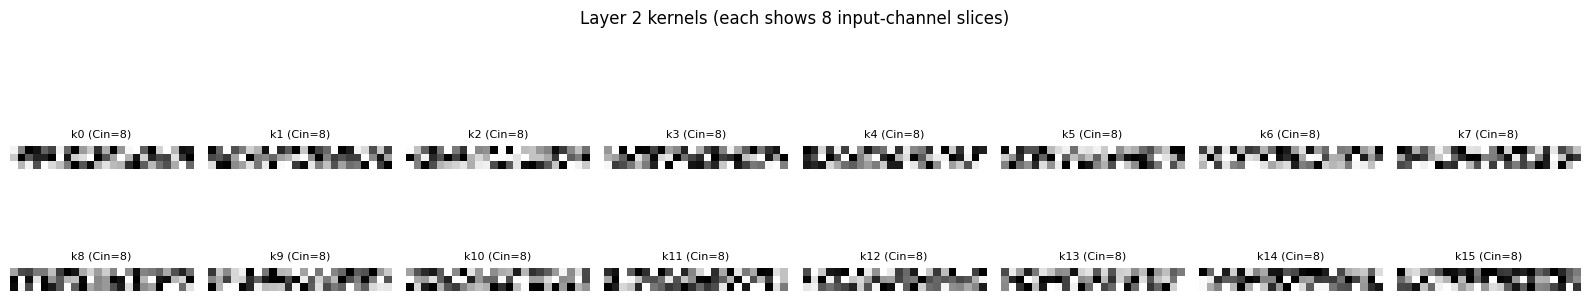

Number of Channels in Feature Map: 16
Feature Map Dimension (H x W): 112 x 112


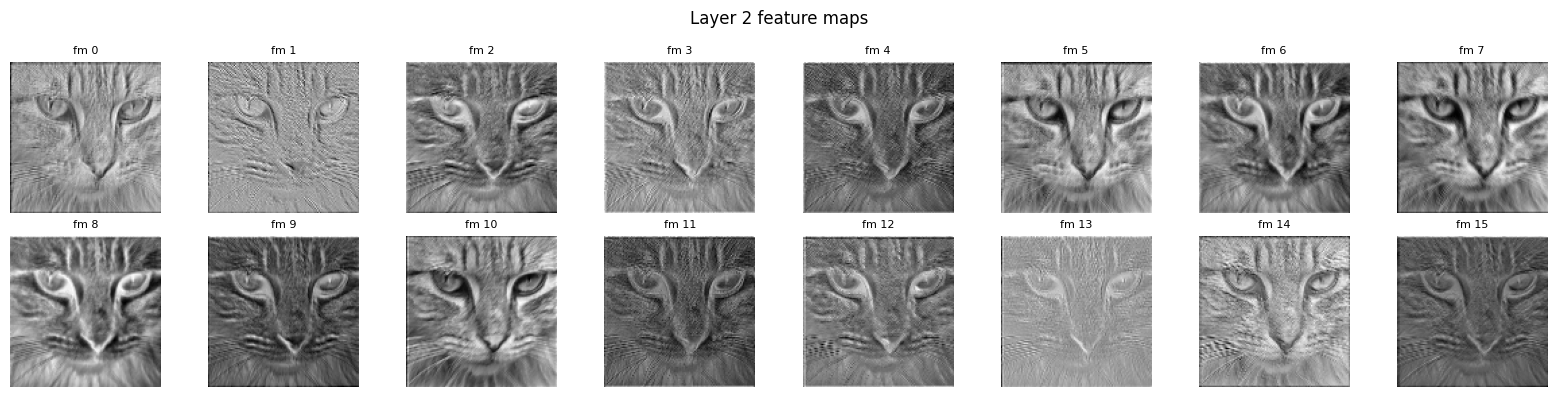

In [8]:
# Visualize kernels (weights) and feature maps
show_conv_kernels(model.conv1.weight, f"Layer 1 kernels (each shows {model.conv1.in_channels} input-channel slices)", per_row=8, show_channel_slices=True)
show_feature_maps(acts["conv1"], "Layer 1 feature maps", per_row=8)

show_conv_kernels(model.conv2.weight, f"Layer 2 kernels (each shows {model.conv2.in_channels} input-channel slices)", per_row=8, show_channel_slices=True)
show_feature_maps(acts["conv2"], "Layer 2 feature maps", per_row=8)

In [9]:
# Clean up hooks (good hygiene)
h1.remove(); h2.remove()

### ResNet50 Pretrained Weights [Optional]

In [10]:
# =========================
# 1) Load pretrained ResNet-50 + transforms
# =========================
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights).eval()        # pretrained backbone
preproc = weights.transforms()                  # correct Resize/CenterCrop/Normalize for ImageNet

# In case you skip the first section
IMG_PATH = 'cat.png'                            # Update to the path to your input image
img = Image.open(IMG_PATH).convert("RGB")
x = preproc(img).unsqueeze(0)                   # [1,3,224,224]

In [20]:
# =========================
# 2) List all layer names (dotted paths)
# =========================
def iter_named_leaf_modules(module, prefix=""):
    """
    Yields (dotted_name, submodule) for *leaf* modules (i.e., that have no children),
    e.g., 'conv1', 'layer1.0.conv2', 'layer3.4.bn3', 'fc', ...
    Leaf modules are typically where weights live (Conv2d, BatchNorm2d, Linear, etc.).
    """
    has_child = False
    for name, child in module.named_children():
        has_child = True
        child_prefix = f"{prefix}.{name}" if prefix else name
        yield from iter_named_leaf_modules(child, child_prefix)
    if not has_child:
        yield prefix, module

def iter_all_named_modules(module, prefix=""):
    """
    Yields (dotted_name, module) for *all* modules (both containers and leaves),
    useful if you want to hook at containers like 'layer2' or 'layer1.0'.
    """
    yield prefix, module
    for name, child in module.named_children():
        child_prefix = f"{prefix}.{name}" if prefix else name
        yield from iter_all_named_modules(child, child_prefix)

# Collect both lists for convenience
leaf_modules = list(iter_named_leaf_modules(model))
all_modules  = list(iter_all_named_modules(model))

'''
print("---- ALL MODULES (containers + leaves) ----")
for name, mod in all_modules:
    cls = mod.__class__.__name__
    print(f"{name:30s}  ({cls})")
'''

print("\n---- LEAF MODULES (good hook/weight targets) ----")
for name, mod in leaf_modules:
    cls = mod.__class__.__name__
    print(f"{name:30s}  ({cls})")


---- LEAF MODULES (good hook/weight targets) ----
conv1                           (Conv2d)
bn1                             (BatchNorm2d)
relu                            (ReLU)
maxpool                         (MaxPool2d)
layer1.0.conv1                  (Conv2d)
layer1.0.bn1                    (BatchNorm2d)
layer1.0.conv2                  (Conv2d)
layer1.0.bn2                    (BatchNorm2d)
layer1.0.conv3                  (Conv2d)
layer1.0.bn3                    (BatchNorm2d)
layer1.0.relu                   (ReLU)
layer1.0.downsample.0           (Conv2d)
layer1.0.downsample.1           (BatchNorm2d)
layer1.1.conv1                  (Conv2d)
layer1.1.bn1                    (BatchNorm2d)
layer1.1.conv2                  (Conv2d)
layer1.1.bn2                    (BatchNorm2d)
layer1.1.conv3                  (Conv2d)
layer1.1.bn3                    (BatchNorm2d)
layer1.1.relu                   (ReLU)
layer1.2.conv1                  (Conv2d)
layer1.2.bn1                    (BatchNorm2d)
layer

In [12]:
# =========================
# 3) Helper: fetch a submodule by dotted name
# =========================
def get_submodule_by_name(root: nn.Module, dotted: str) -> nn.Module:
    """
    Example: get_submodule_by_name(model, "layer3.4.conv2")
    """
    mod = root
    if dotted == "" or dotted is None:
        return mod
    for part in dotted.split("."):
        mod = getattr(mod, part)
    return mod

In [22]:
# =========================
# 4) Choose layers to visualize
#    - You can pick from *any* names that were printed above.
#    - For kernels: pick layers that are nn.Conv2d (weights shape [Cout, Cin, kH, kW])
# =========================
LAYER_FOR_FMAPS = [
    "conv1",           # very first conv (64x downsample after stride/pool)
    "layer1.0.conv2",  # inside first residual block
    "layer2.0.conv2",
    "layer3.0.conv2",
    "layer4.0.conv2",
]
LAYER_FOR_KERNELS = [
    "conv1",
    "layer1.0.conv2",
    "layer2.1.conv2",
    # add any '...conv*' you like from the printed list
]

In [14]:
# =========================
# 5) Register forward hooks for feature maps
# =========================
activations = {}
_hooks = []

def _save_act(name):
    def hook(m, i, o):
        activations[name] = o
    return hook

for lname in LAYER_FOR_FMAPS:
    mod = get_submodule_by_name(model, lname)
    _hooks.append(mod.register_forward_hook(_save_act(lname)))


In [15]:
# =========================
# 6) Forward pass to populate feature maps
# =========================
with torch.no_grad():
    _ = model(x)

Number of Channels in Feature Map: 64
Feature Map Dimension (H x W): 112 x 112


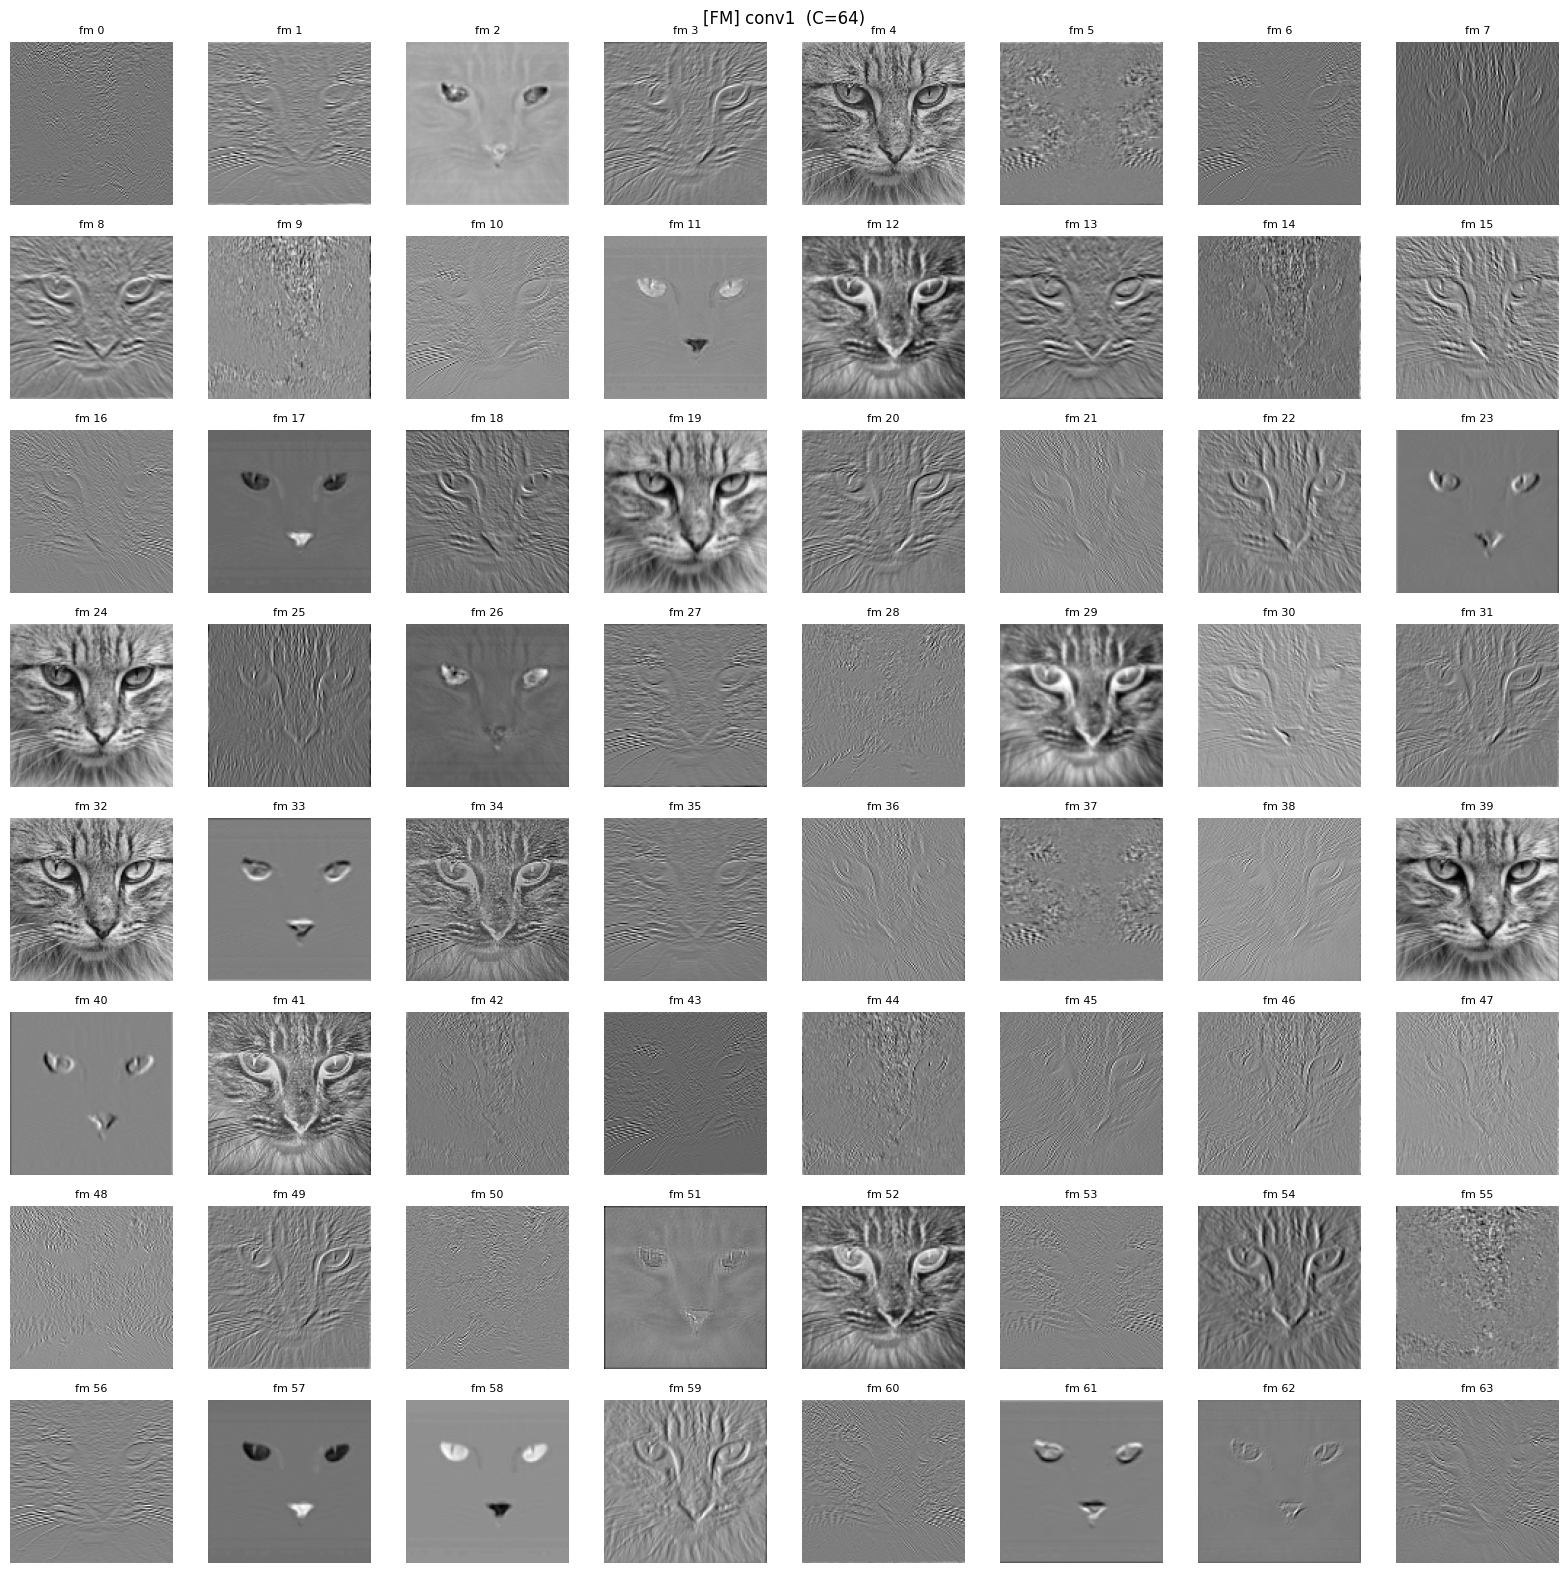

Number of Channels in Feature Map: 64
Feature Map Dimension (H x W): 56 x 56


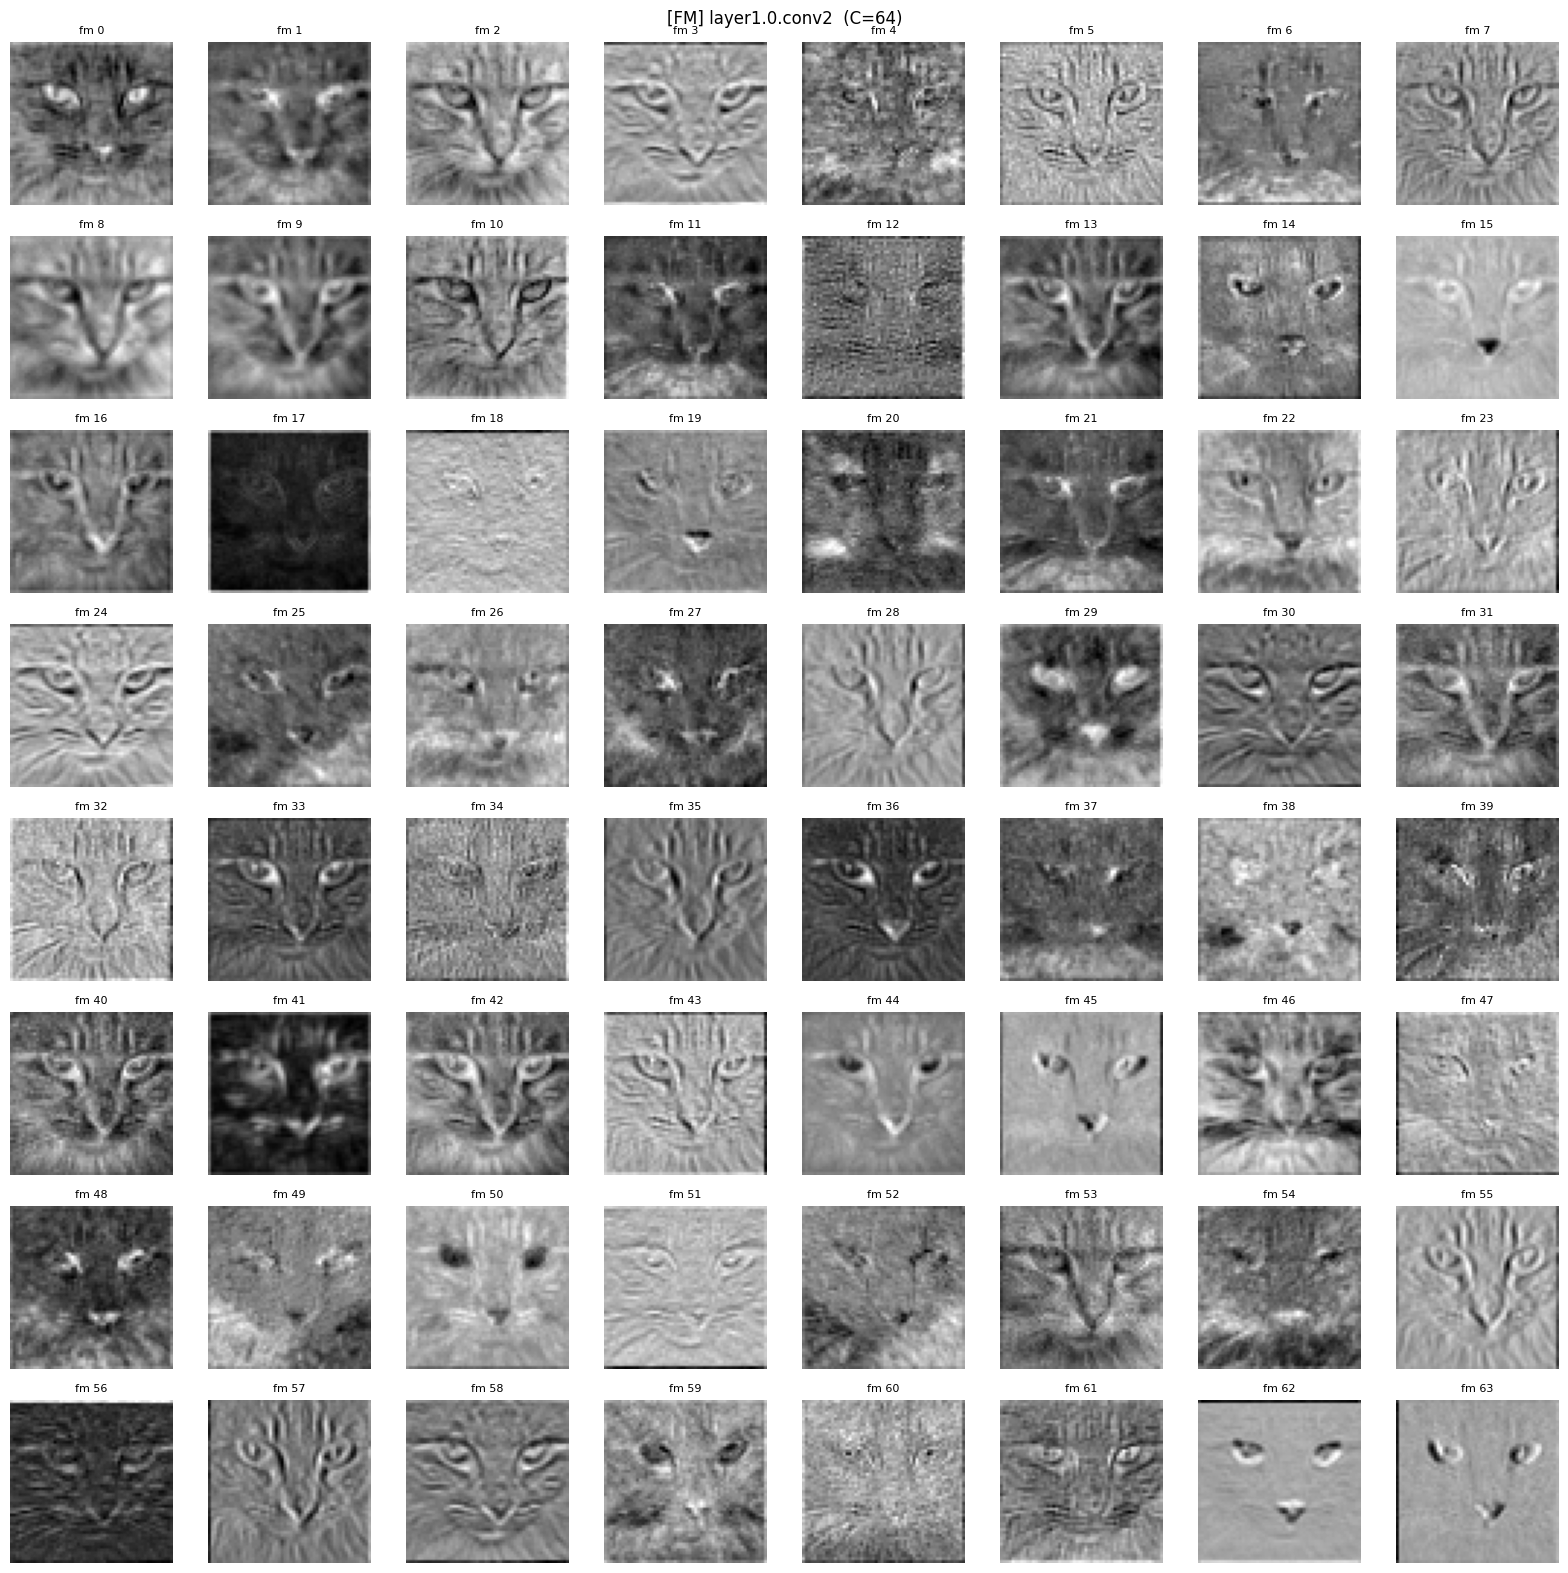

Number of Channels in Feature Map: 128
Feature Map Dimension (H x W): 28 x 28


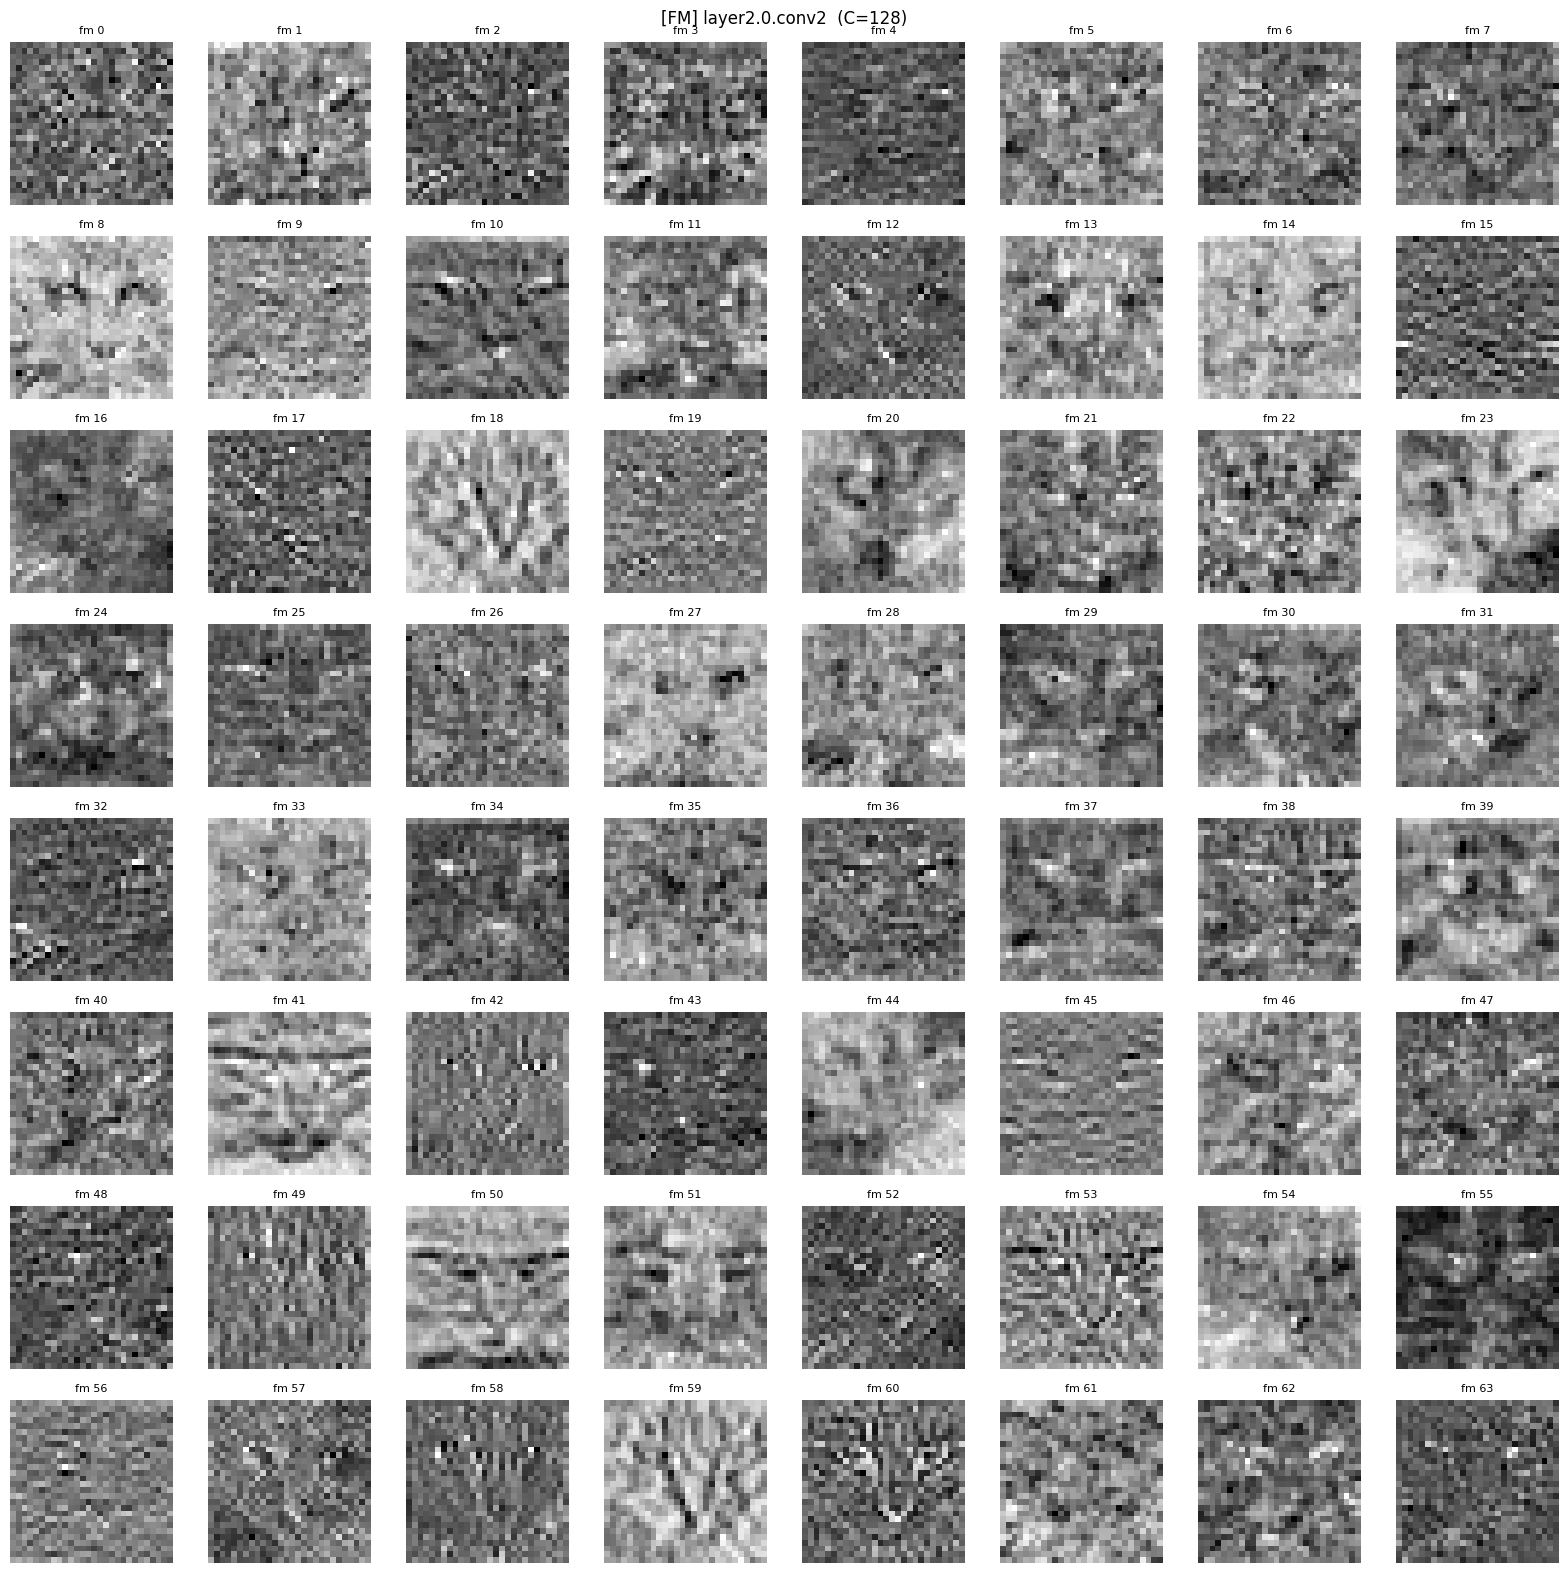

Number of Channels in Feature Map: 256
Feature Map Dimension (H x W): 14 x 14


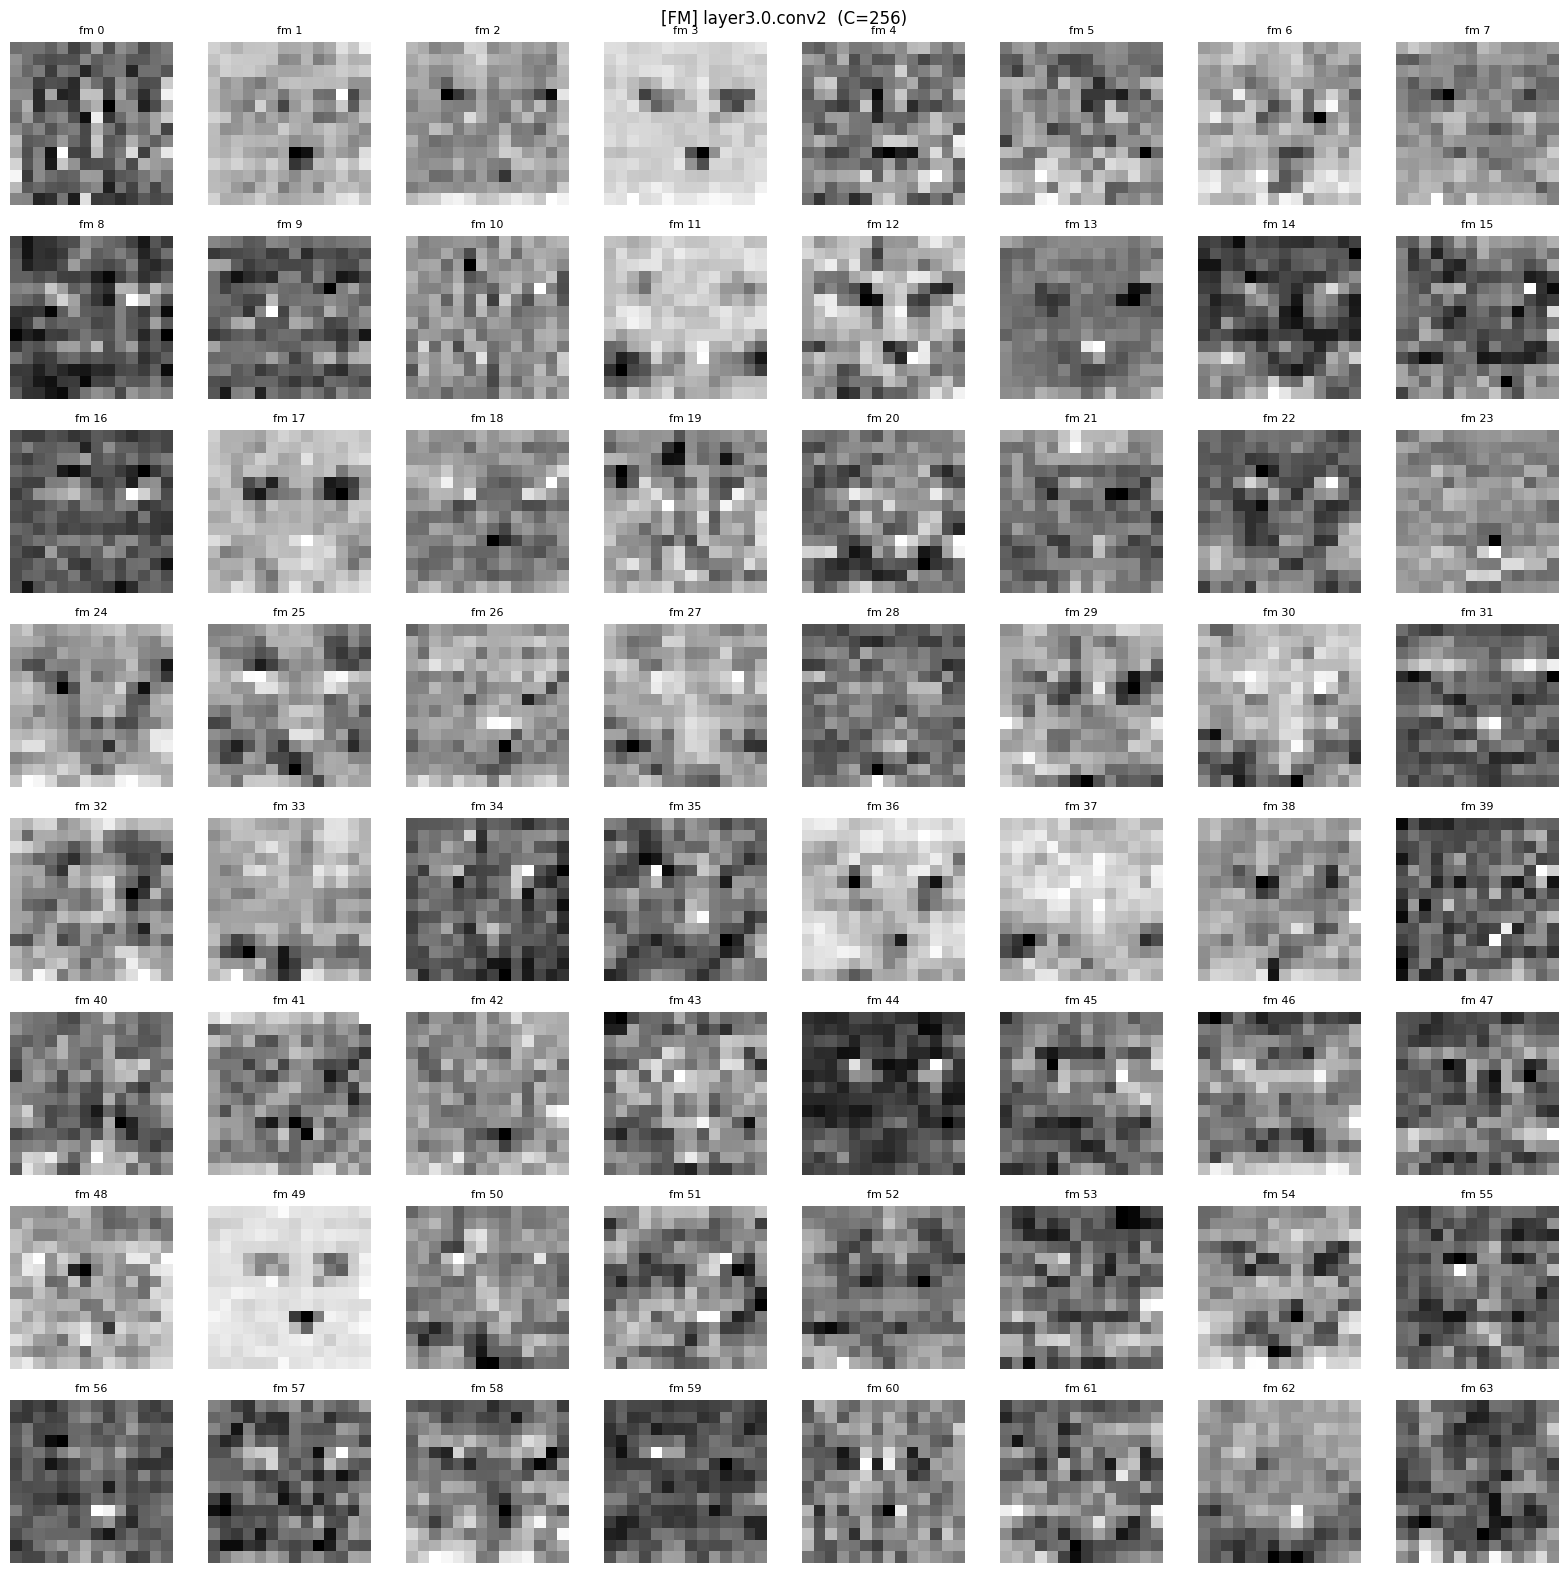

Number of Channels in Feature Map: 512
Feature Map Dimension (H x W): 7 x 7


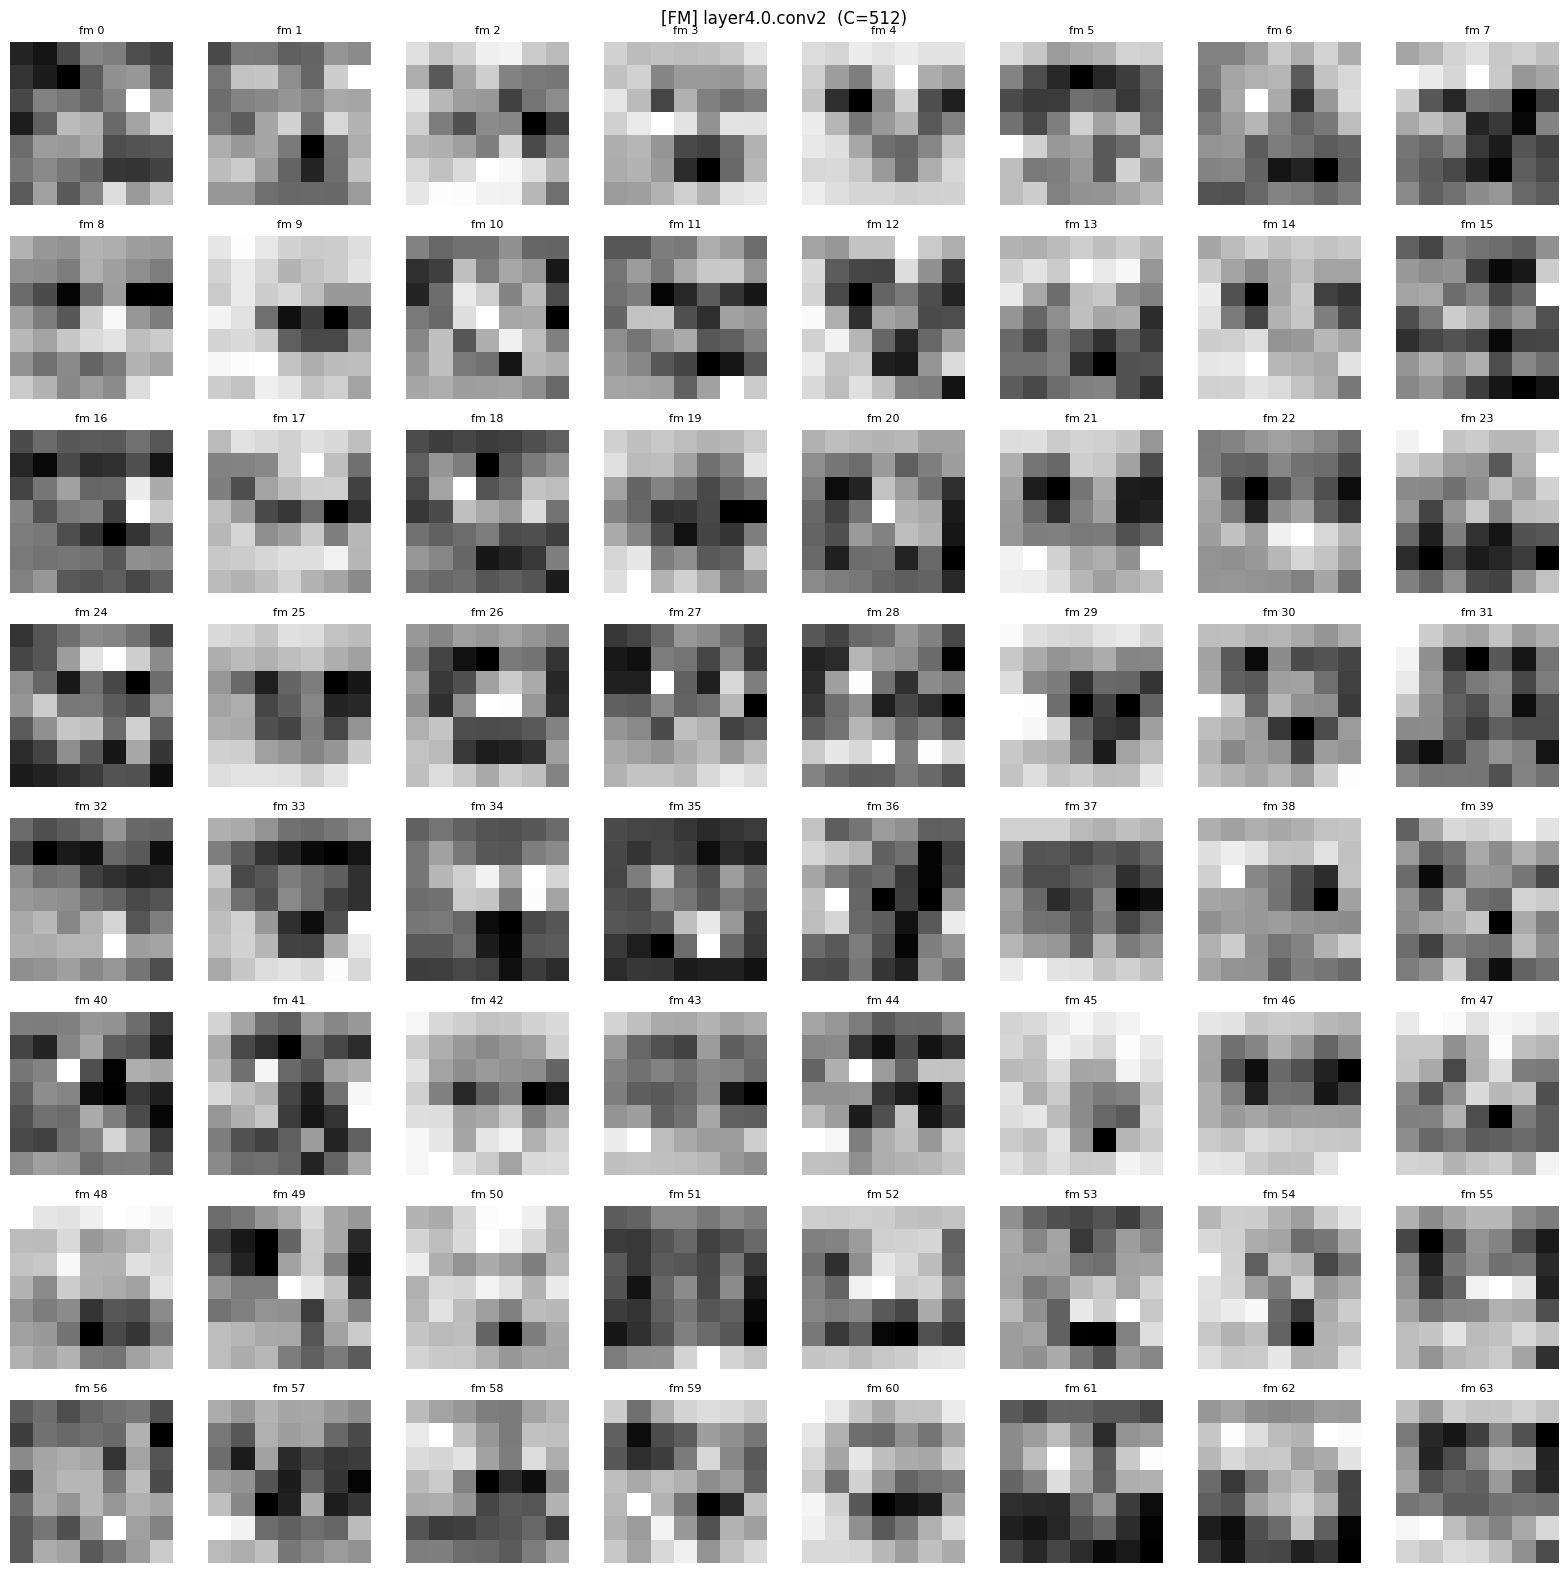

In [16]:
# =========================
# 7) Visualize: Feature maps
# =========================
for lname in LAYER_FOR_FMAPS:
    feat = activations[lname]   # [1, C, H, W]
    C = feat.shape[1]
    show_feature_maps(feat, title=f"[FM] {lname}  (C={C})",
                      per_row=8,
                      limit=min(C, 64)) # ResNet can have large number of filters, we limit the number of feature maps shown


Number of Kernels: 64
Each Kernel has 3 Channels - coming from previous layer.
Kernel Dimension (kH x kW): 7 x 7


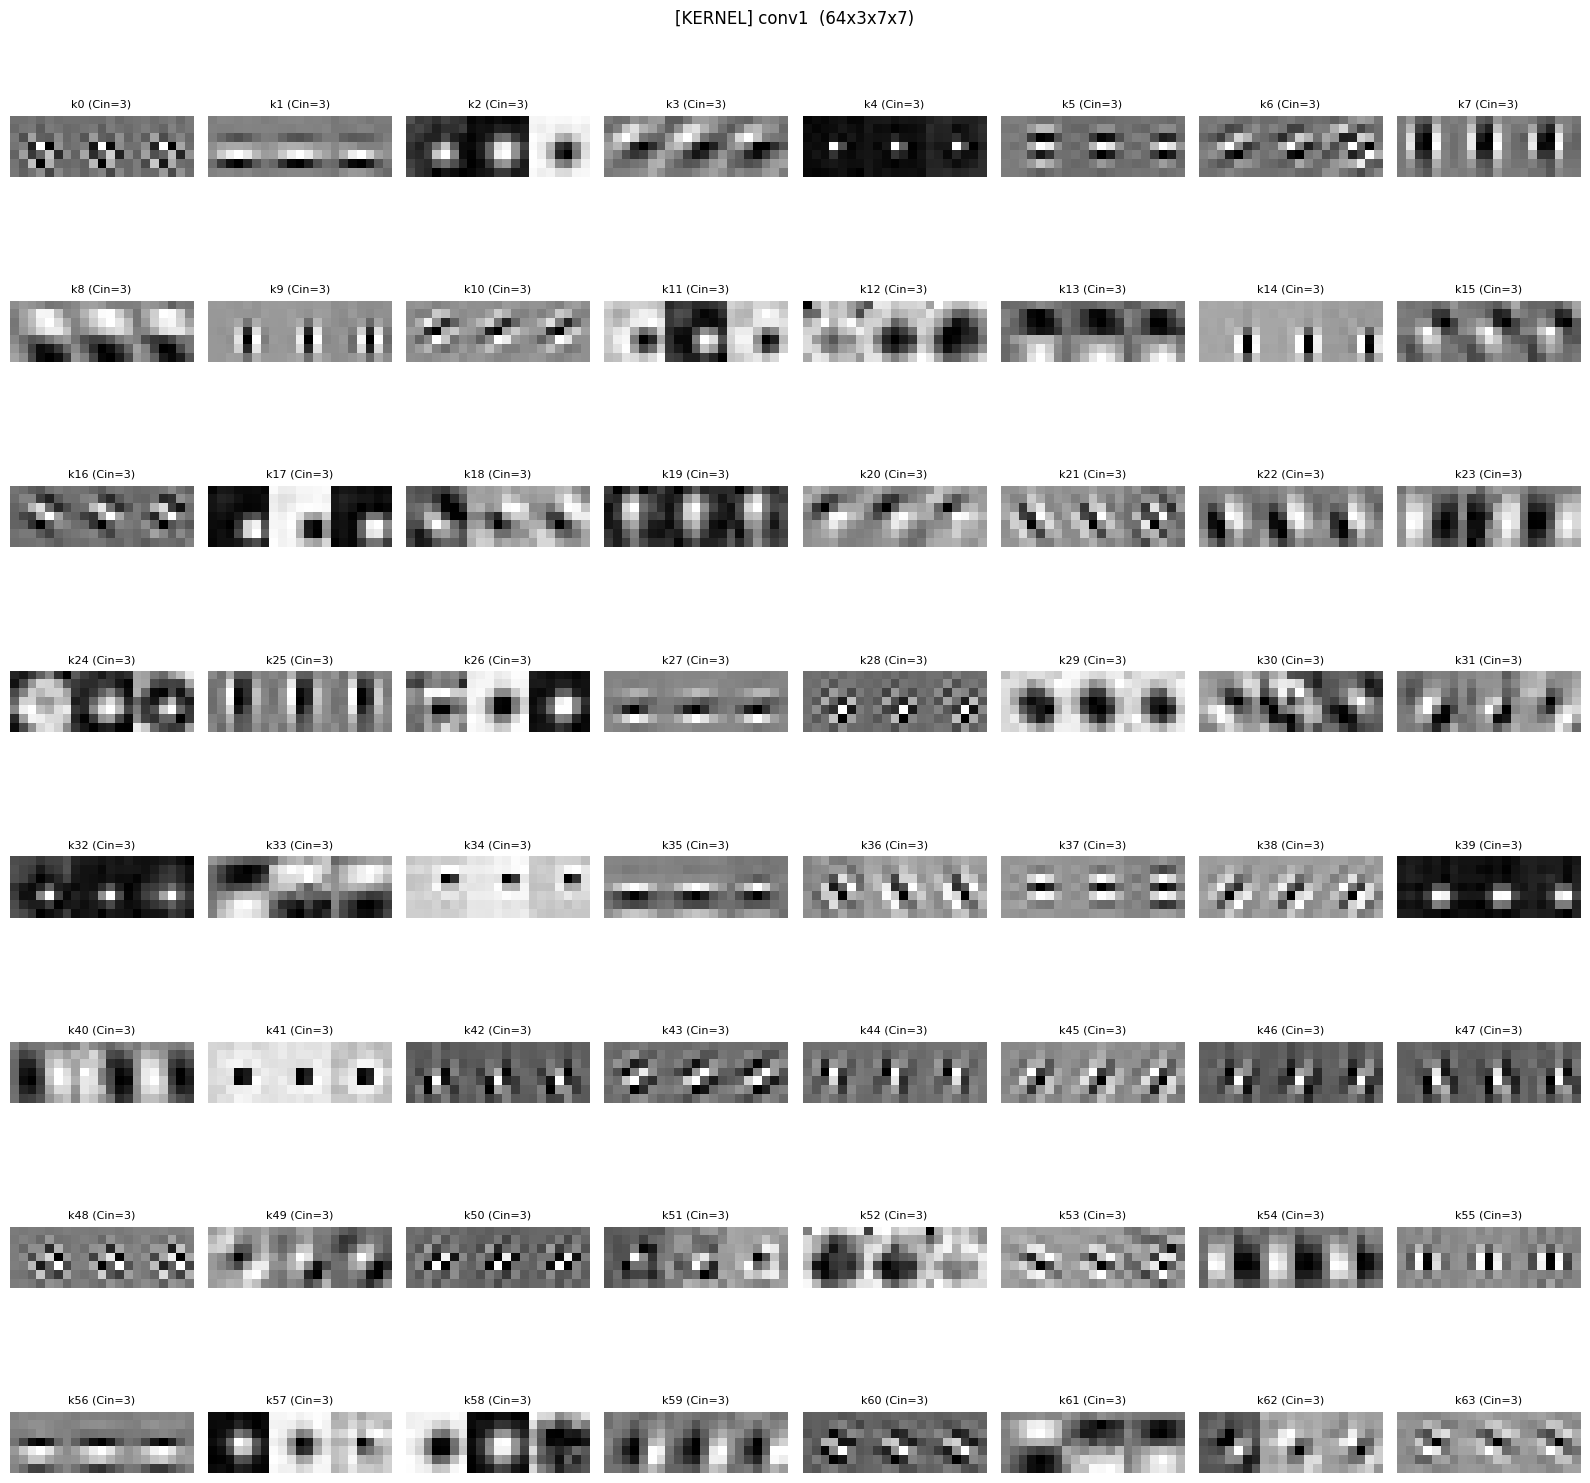

Number of Kernels: 64
Each Kernel has 64 Channels - coming from previous layer.
Kernel Dimension (kH x kW): 3 x 3


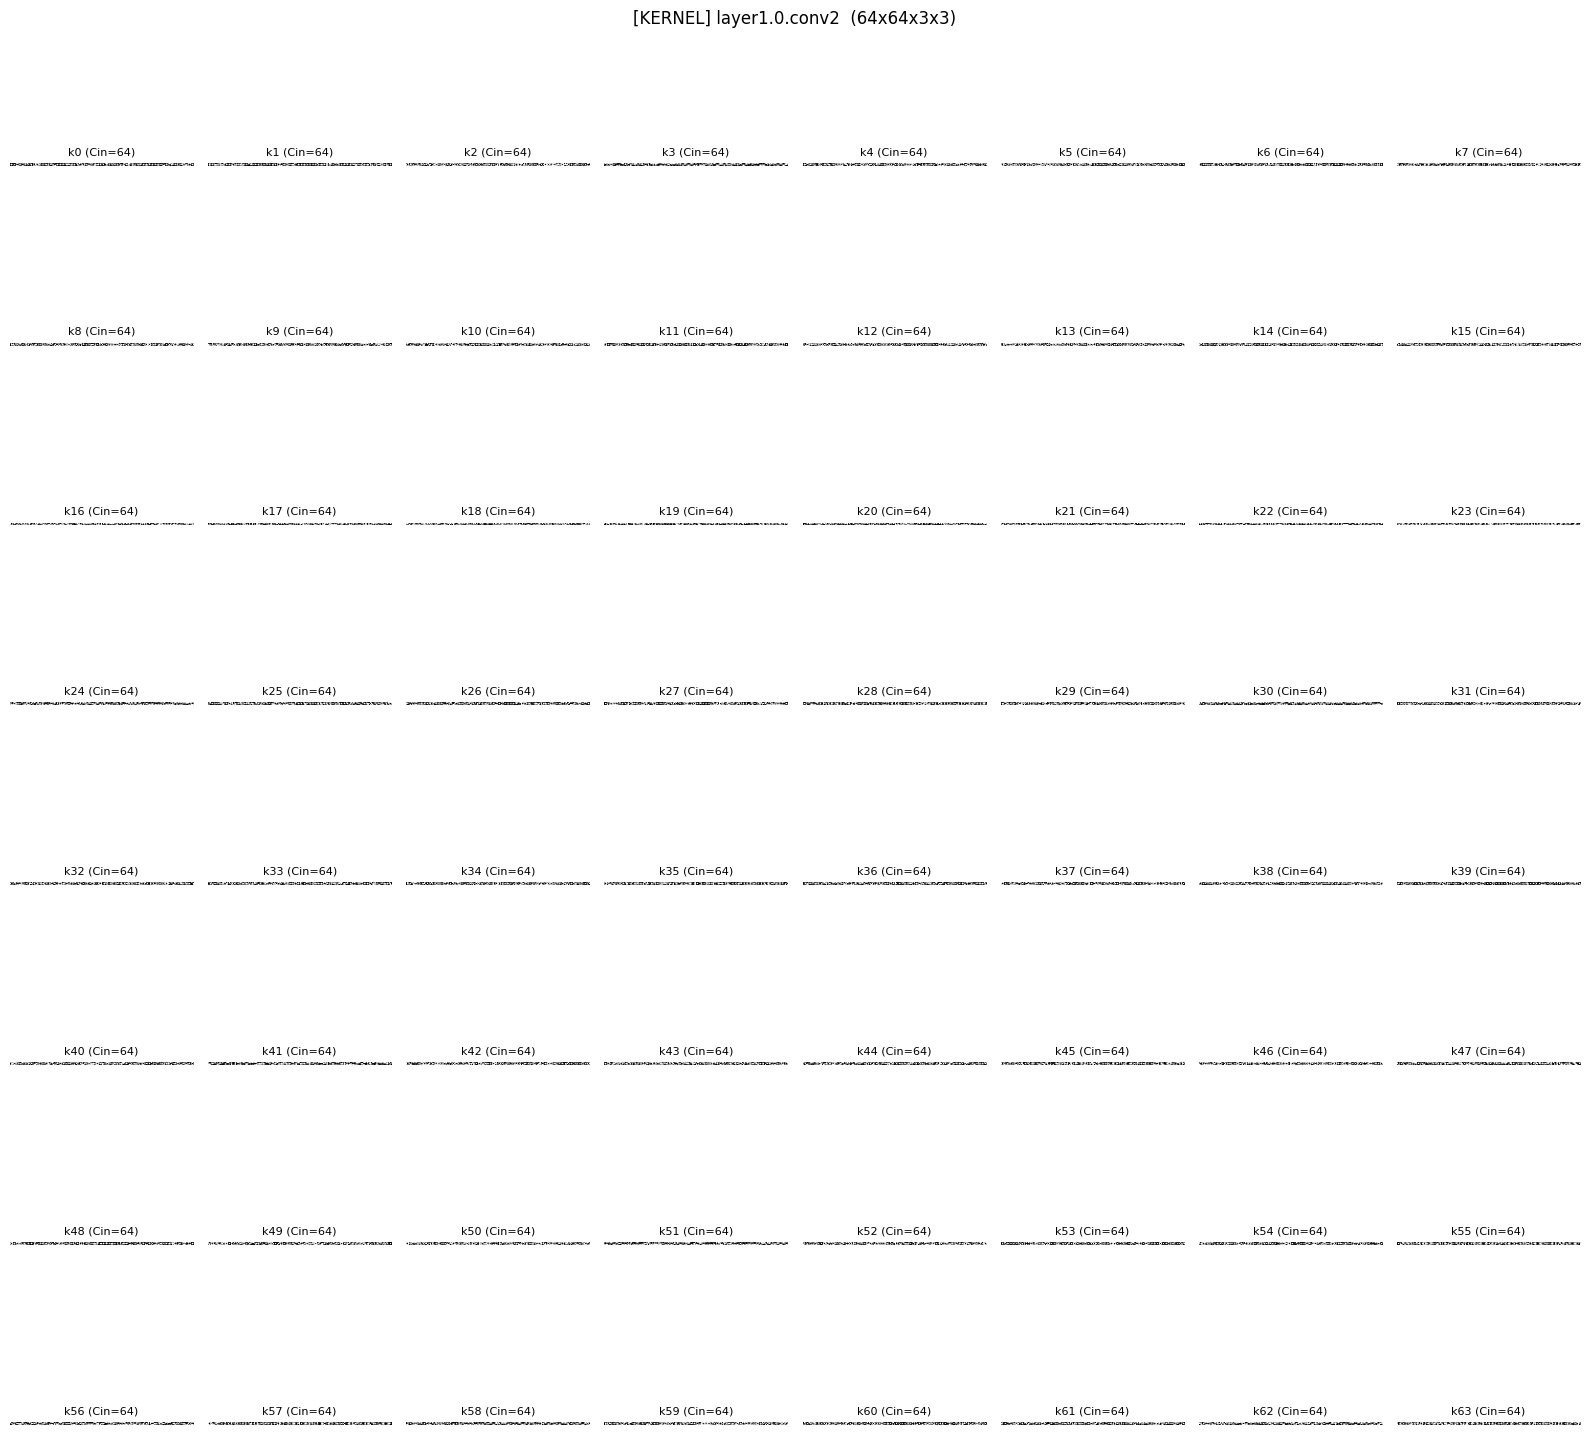

Number of Kernels: 128
Each Kernel has 128 Channels - coming from previous layer.
Kernel Dimension (kH x kW): 3 x 3


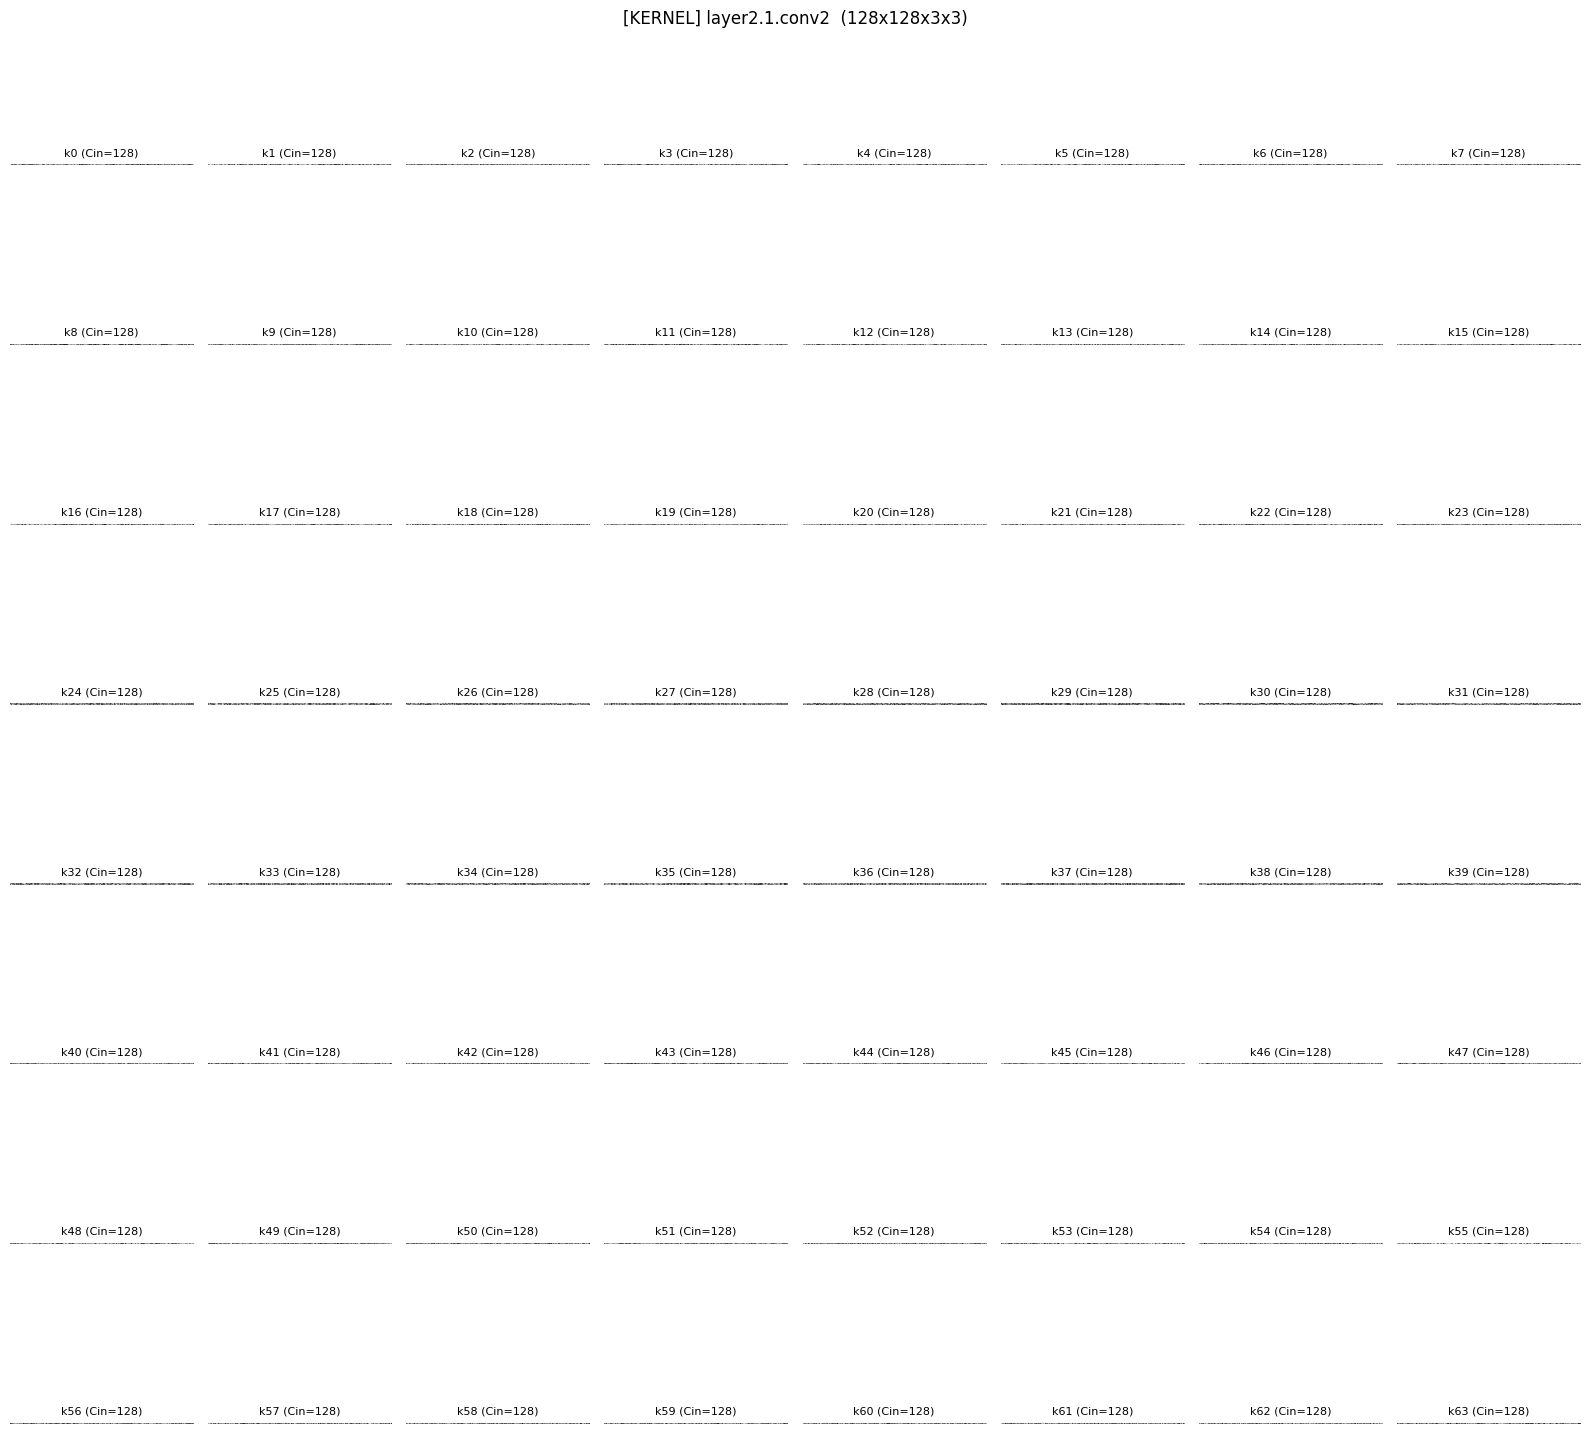

In [23]:
# =========================
# 8) Visualize: Kernels (Conv2d weights)
# =========================
for lname in LAYER_FOR_KERNELS:
    mod = get_submodule_by_name(model, lname)
    if isinstance(mod, nn.Conv2d):
        W = mod.weight  # [Cout, Cin, kH, kW]
        Cout, Cin, kH, kW = W.shape
        show_conv_kernels(W, title=f"[KERNEL] {lname}  ({Cout}x{Cin}x{kH}x{kW})",
                          per_row=8, show_channel_slices=True, limit=64)
    else:
        print(f"[skip] {lname} is {mod.__class__.__name__}, not Conv2d")

In [18]:
# =========================
# 9) Clean up hooks
# =========================
for h in _hooks:
    h.remove()

Plotting RGB Filter for comparision with the Grayscale Kernels printed above.

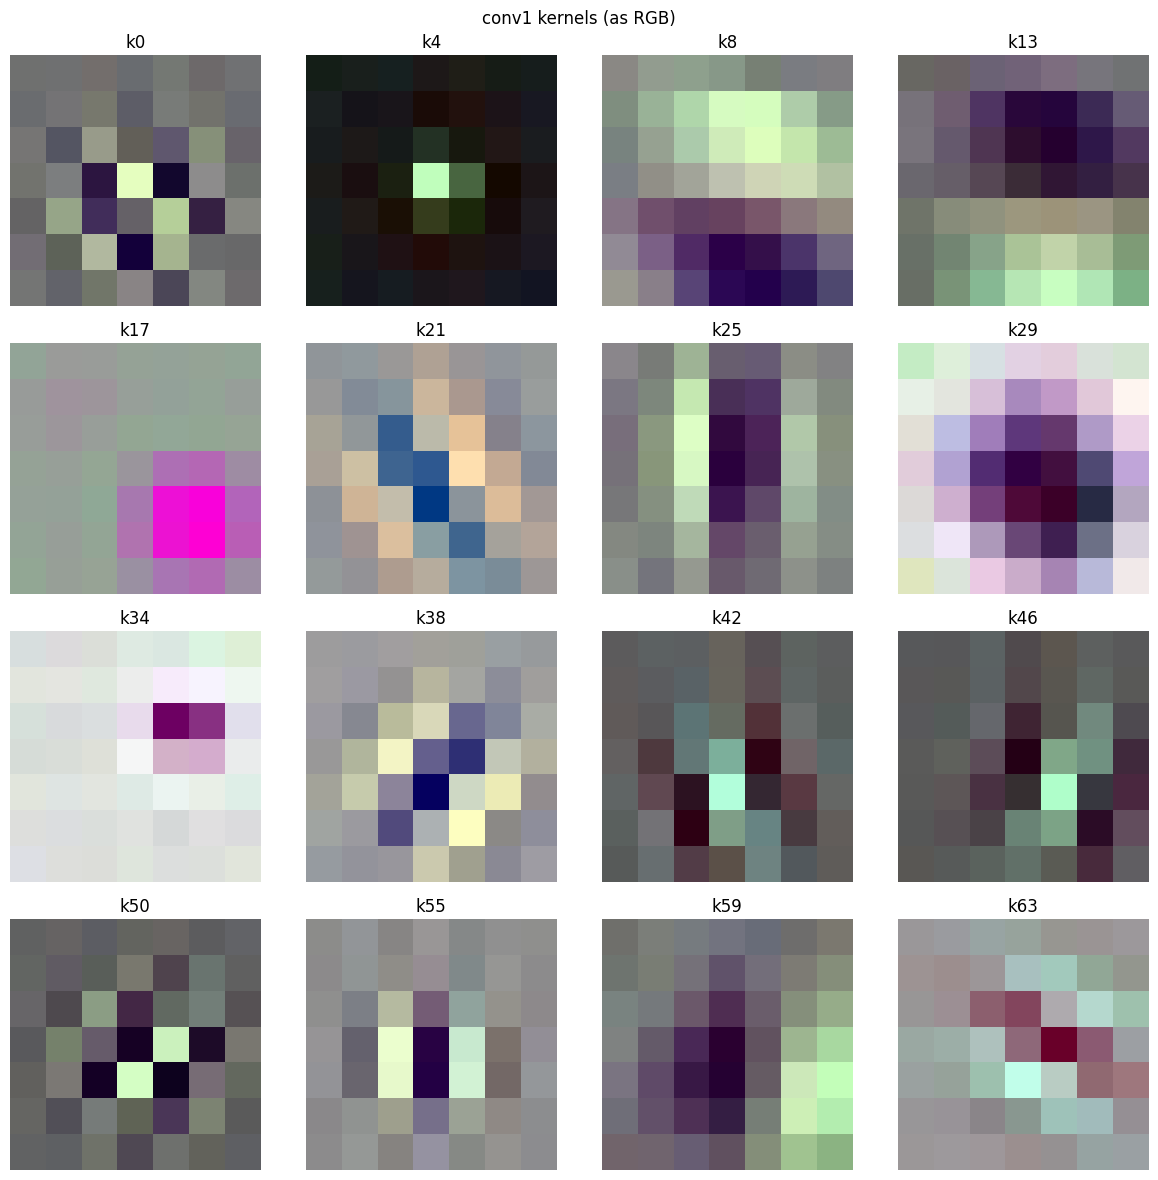

In [24]:
name_to_module = dict(model.named_modules())

def get_weight(module):
    return module.weight.detach().cpu()  # [K,C,Kh,Kw]

# 7x7 first layer filters as RGB (assuming 3 input channels)
w = get_weight(name_to_module['conv1'])  # [K,3,7,7]
# Normalize per-filter for display
def norm01(x):
    return (x - x.min()) / (x.max() - x.min() + 1e-6)

def show_conv1_weights(w, max_k=16):
    K = w.shape[0]
    idx = torch.linspace(0, K-1, steps=min(K, max_k)).round().long().tolist()
    cols = 4
    rows = math.ceil(len(idx) / cols)
    plt.figure(figsize=(3*cols, 3*rows))
    for i, k in enumerate(idx, 1):
        filt = w[k]  # [3,Kh,Kw]
        # Convert to H×W×3
        filt_rgb = filt.permute(1,2,0)
        filt_rgb = norm01(filt_rgb)
        plt.subplot(rows, cols, i)
        plt.imshow(filt_rgb.numpy())
        plt.axis('off')
        plt.title(f'k{k}')
    plt.suptitle('conv1 kernels (as RGB)')
    plt.tight_layout()
    plt.show()

show_conv1_weights(w)           # Print out 16 out of 64 filters for illustration purpose